# Fitting And Analyzing Contextualized Models

Let's walk through an example of Contextualized analysis.

# Download and Prepare Data

First, we will load the data into a standard pandas dataframe or a numpy array, and create a train / test split. There's only 1 step of preprocessing required: deciding the context variables..

````{margin}
```{note}
**Deciding context variables is an experiment-driven question.**

Since we will typically interpret the contextualized models in terms of the predictor, it's often helpful to use interpretable variables as the predictors.

In this example, we will use age, sex, and BMI as the contexts to look for context-specific predictors of diabetes progression.
```
````

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

X, Y = load_diabetes(return_X_y=True, as_frame=True)
Y = np.expand_dims(Y.values, axis=-1)
C = X[['age', 'sex', 'bmi']]
X.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

seed = 1
C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.20, random_state=seed)

# Train a Contextualized Model

Contextualized models follow an sklearn-like interface to make training easy.

````{margin}
```{note}
Common constructor keywords include:

- n_bootstraps: The integer number of bootstrap runs to fit.
- encoder_type: 'mlp' or 'ngam', which type of model to make as context encoder.
- alpha: non-negative float, regularization strength.
- mu_ratio: float in range (0.0, 1.0), governs how much the regularization applies to context-specific parameters or context-specific offsets.
- l1_ratio: float in range (0.0, 1.0), governs how much the regularization penalizes l1 vs l2 parameter norms.

Common fitting keywords include:

- max_epochs: positive number, the maximum number of epochs to fit. Early stopping is turned on by default.
- learning_rate: positive float, default is 1e-3.
```
````

In [2]:
%%capture
from contextualized.easy import ContextualizedRegressor
model = ContextualizedRegressor(n_bootstraps=3)
model.fit(C_train.values, X_train.values, Y_train,
          encoder_type="mlp", max_epochs=20,
          learning_rate=1e-3)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

# Save/load the trained model.

In [3]:
from contextualized.utils import save, load

save_path = './easy_demo_model.pt'
save(model, path=save_path)
model = load(save_path)

# Inspect the model predictions.

We can use standard plotting tools to inspect the model predictions.

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

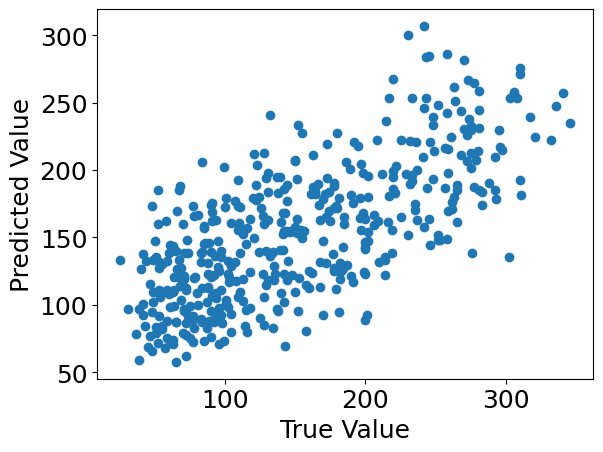

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y[:, 0], model.predict(C.values, X.values)[:, 0])
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

# Check what the individual bootstrap models learned.

Since we bootstrapping for robustness, we can also access individual bootstrap runs with the `individual_preds` keyword to get confidence intervals.

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

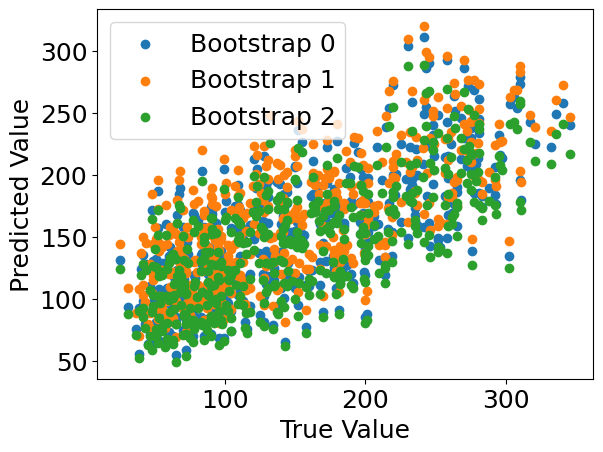

In [5]:
model_preds = model.predict(C.values, X.values, individual_preds=True)
for i, pred in enumerate(model_preds):
    plt.scatter(Y[:, 0], pred[:, 0], label='Bootstrap {}'.format(i))
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

# Check what contextualized parameters the models learned.

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


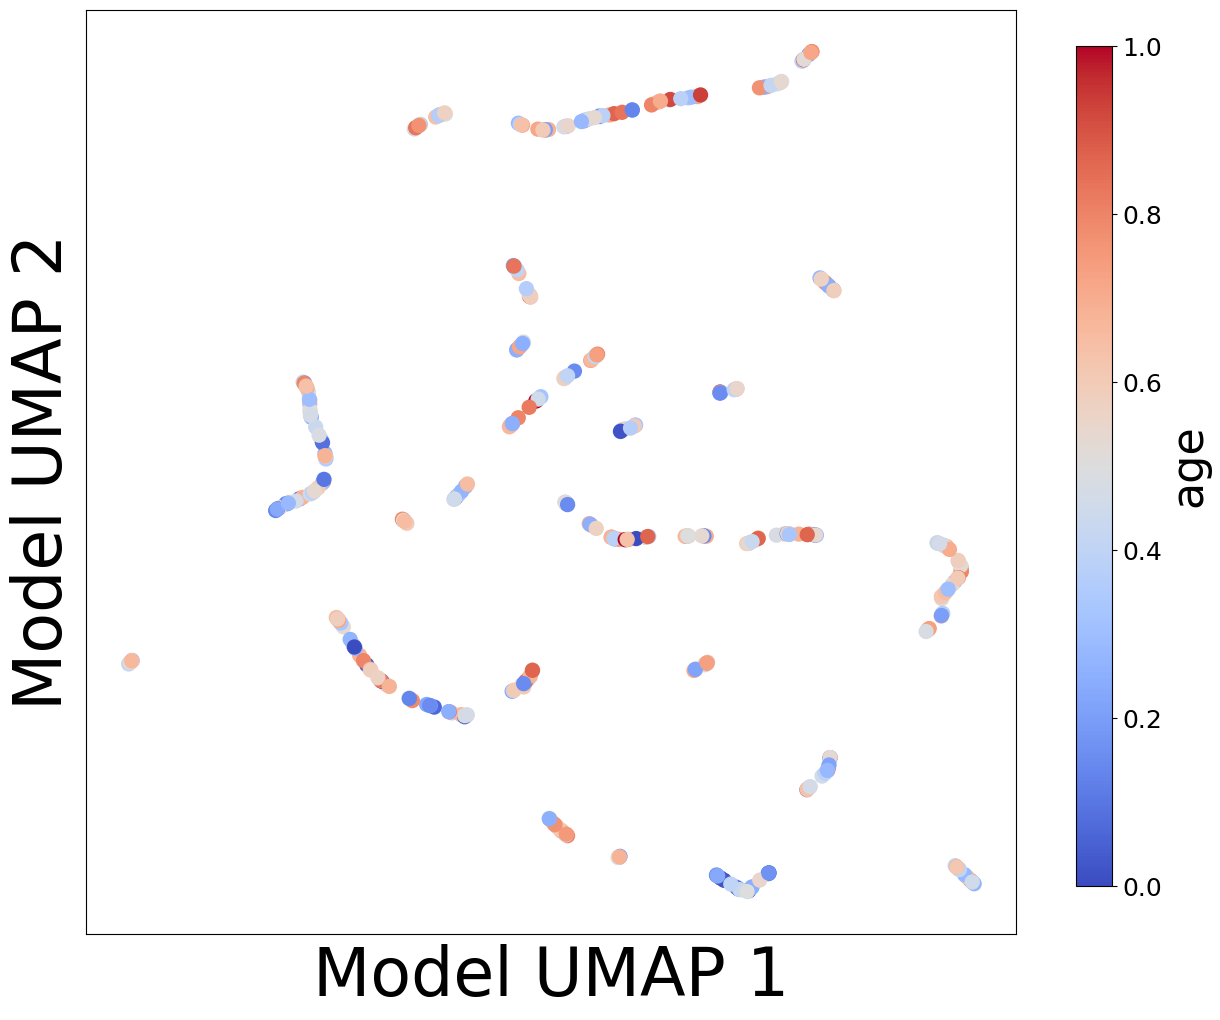

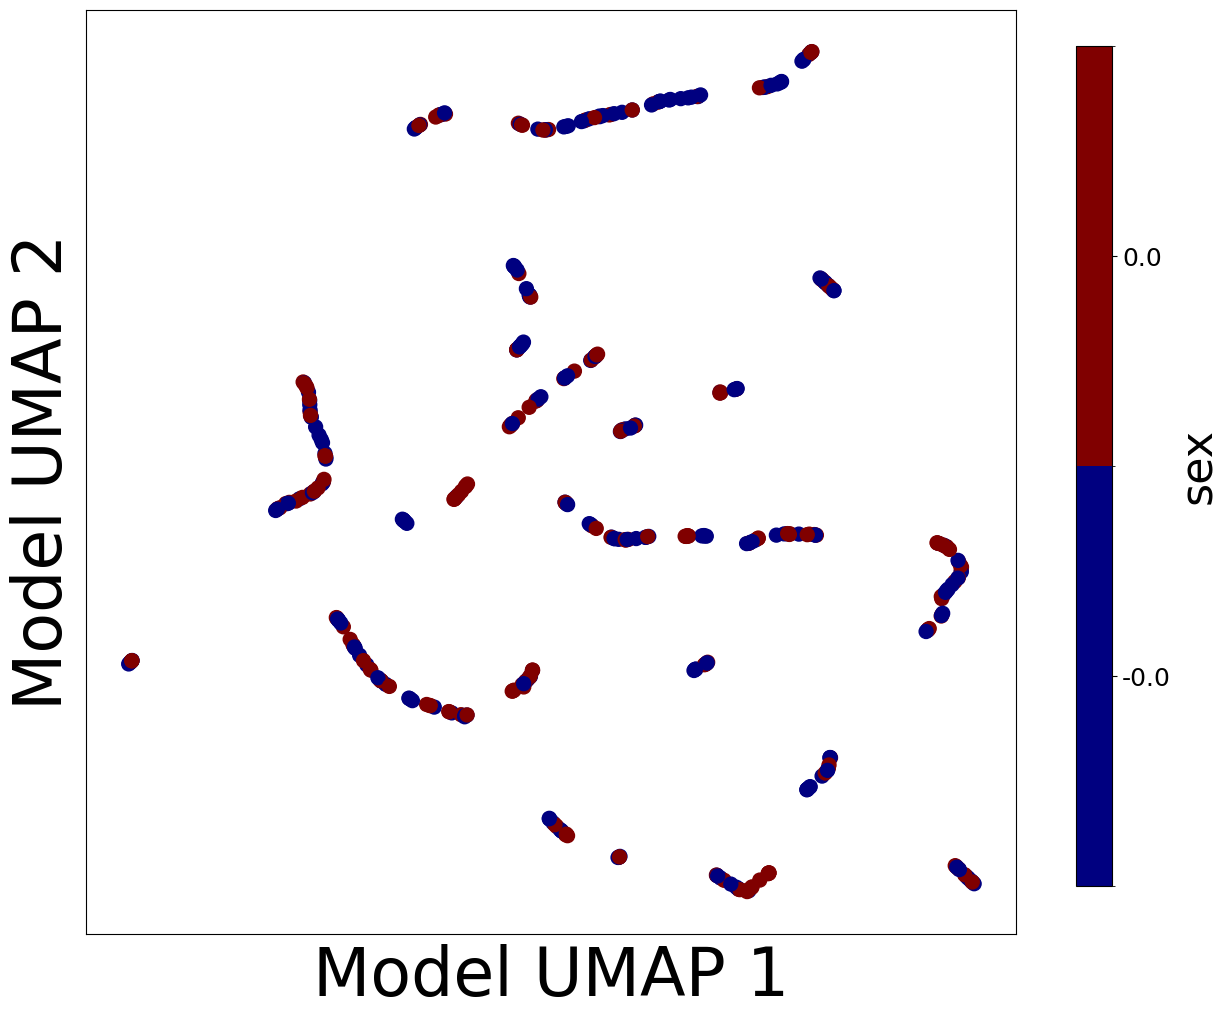

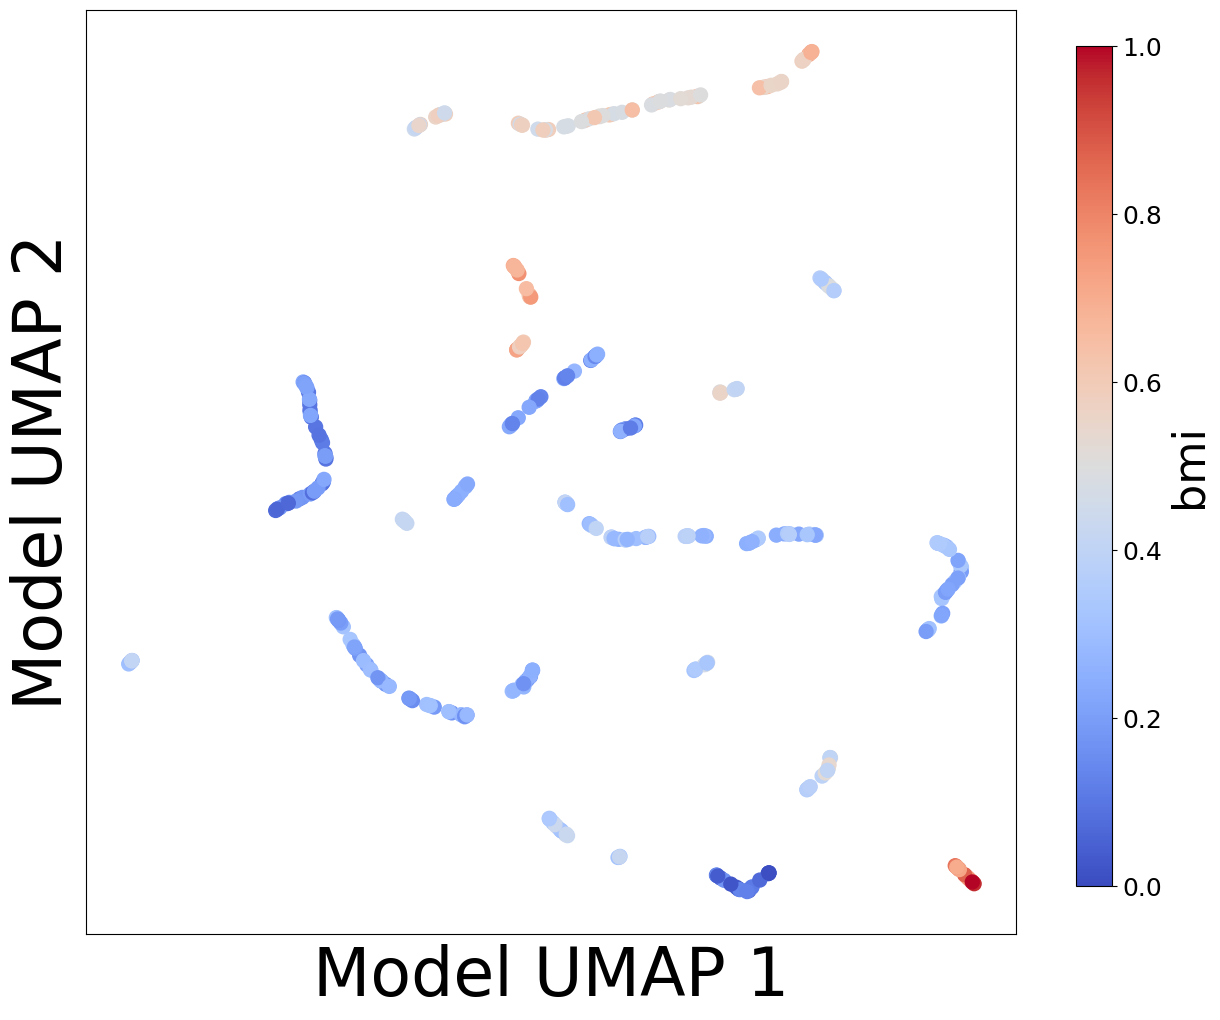

In [6]:
betas, mus = model.predict_params(C.values, individual_preds=False)

# To get a sense of how the models are clusterd, let's embed the models is a 2-D space and visualize them.

# Betas are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
betas = np.squeeze(betas)

from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(betas)

from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model UMAP 1', ylabel='Model UMAP 2')

## What are the homogeneous predictors?

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

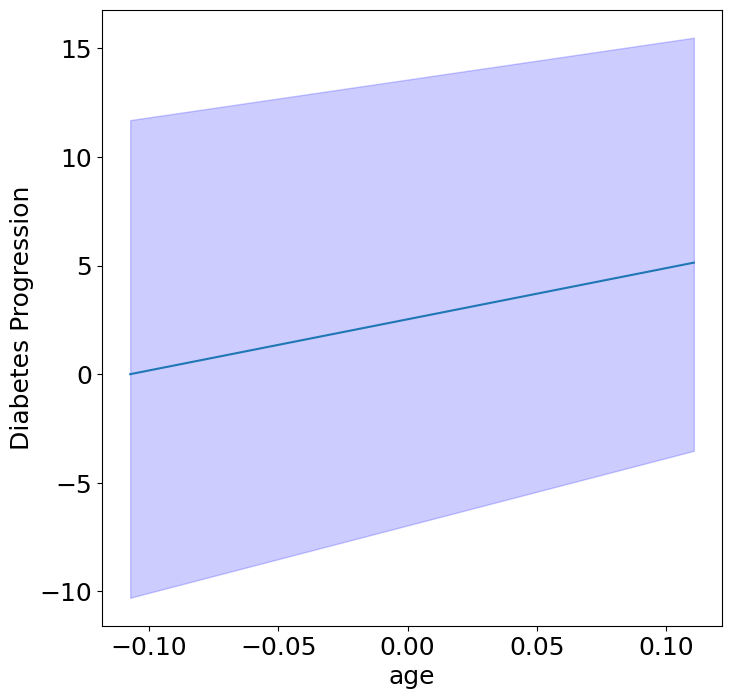

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

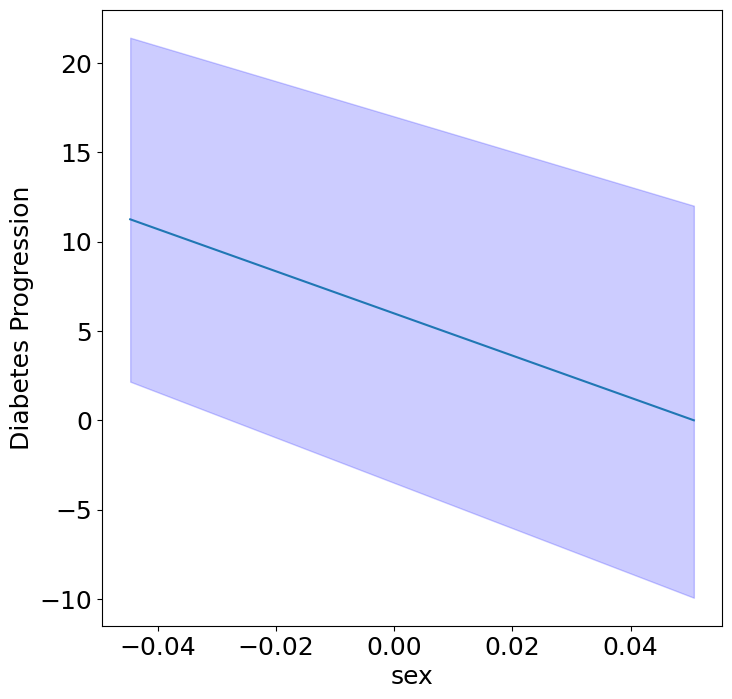

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

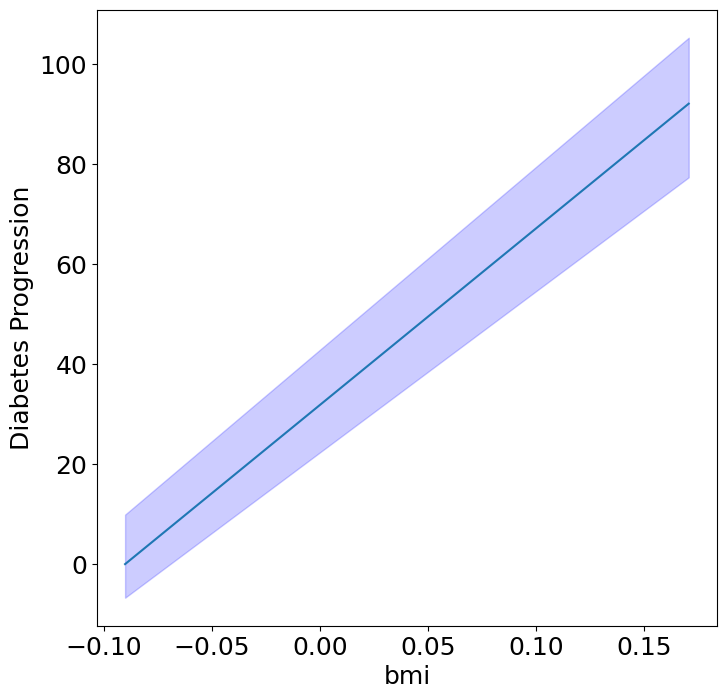

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

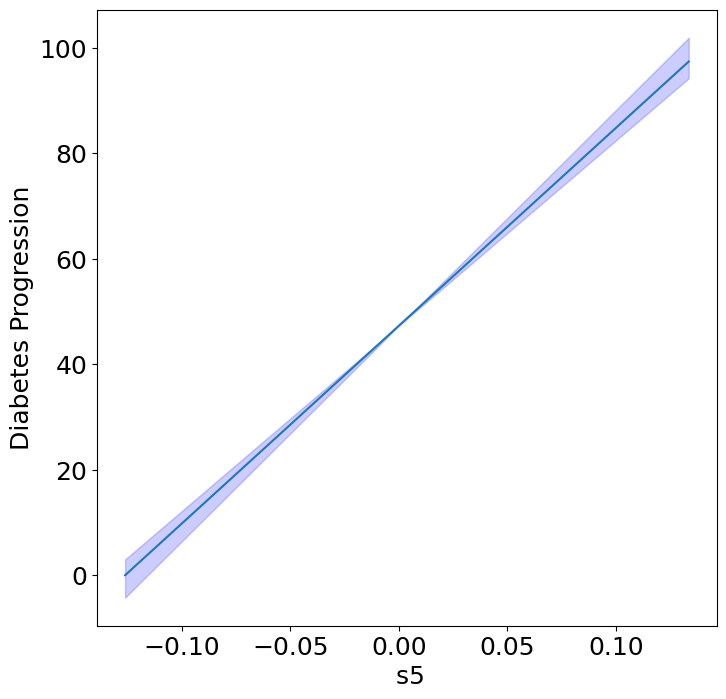

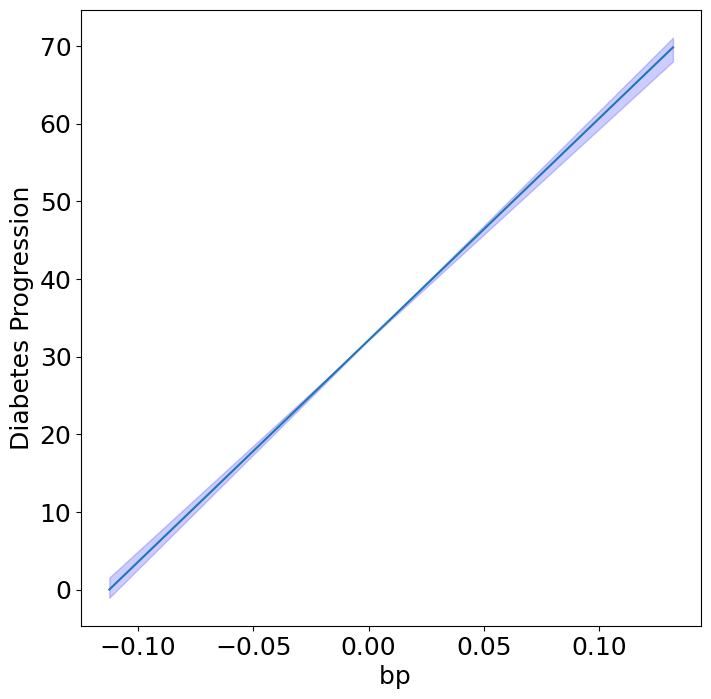

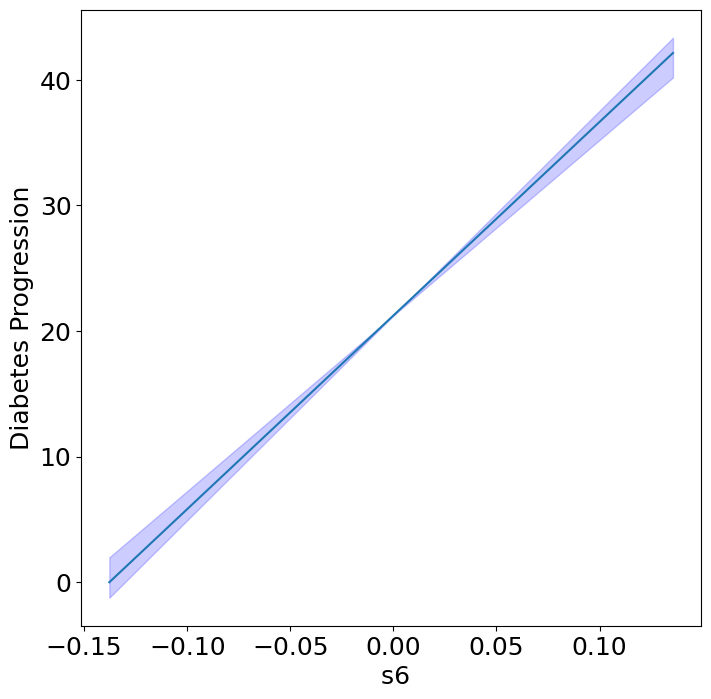

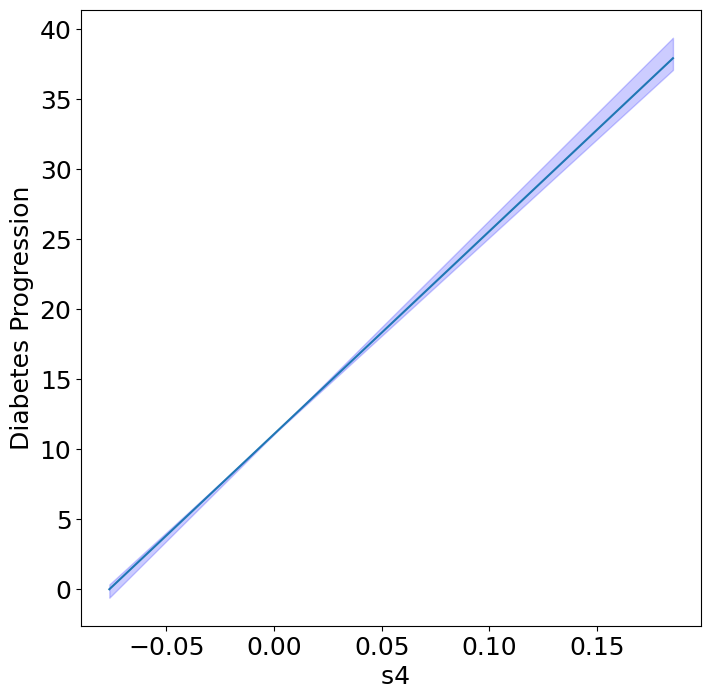

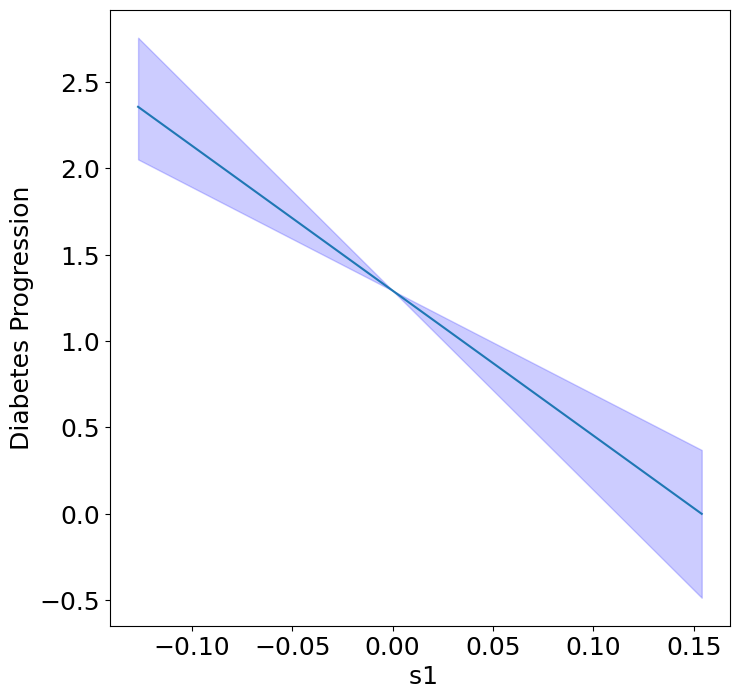

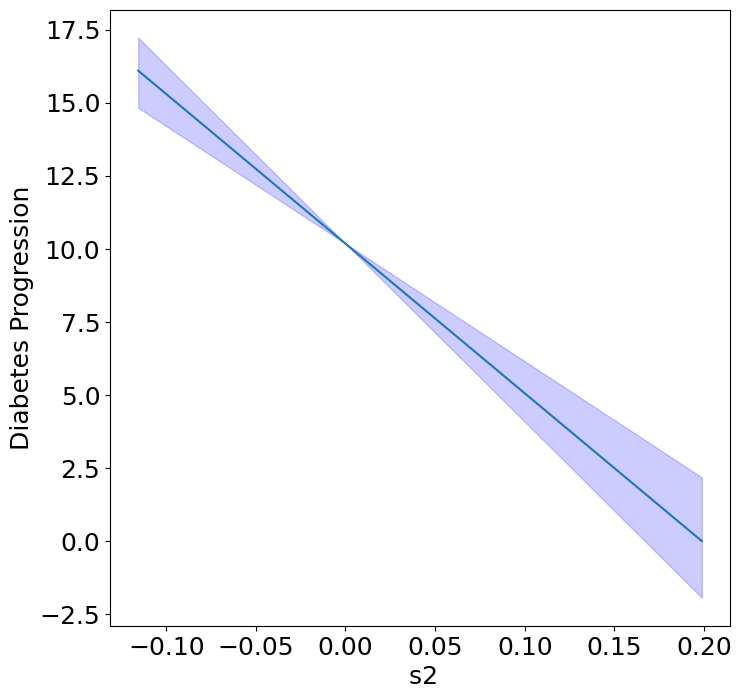

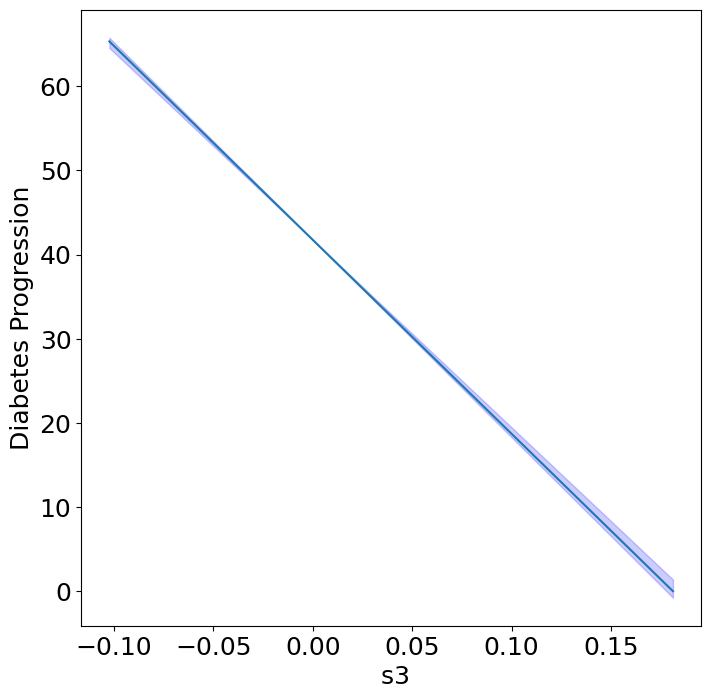

In [7]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

plot_homogeneous_context_effects(
    model, C, 
    classification=False, verbose=False, 
    ylabel="Diabetes Progression")

plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Diabetes Progression",
    classification=False)

## What are the heterogeneous predictors (effects change based on context)?

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

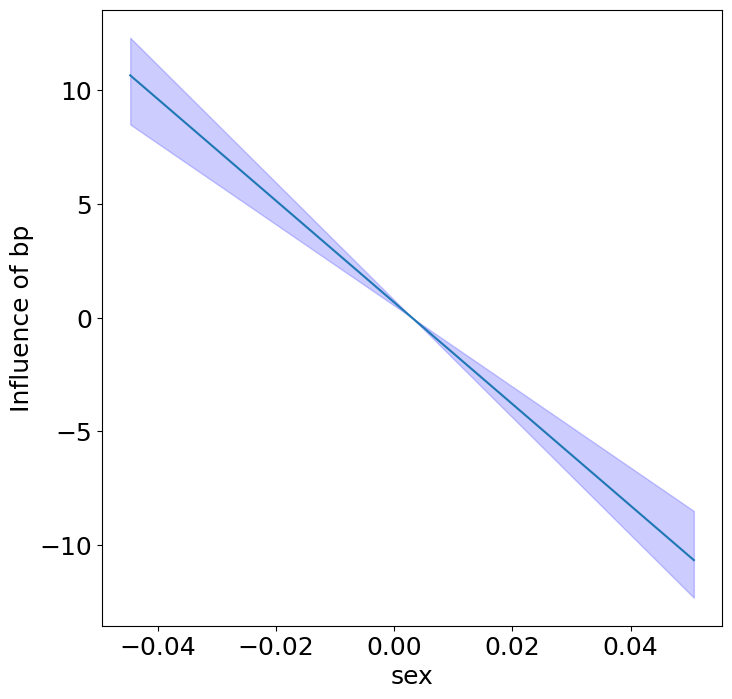

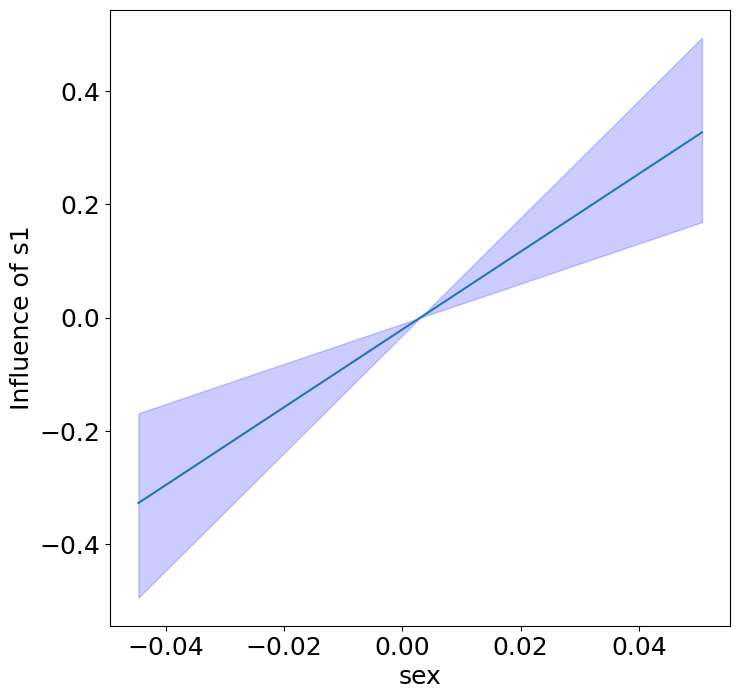

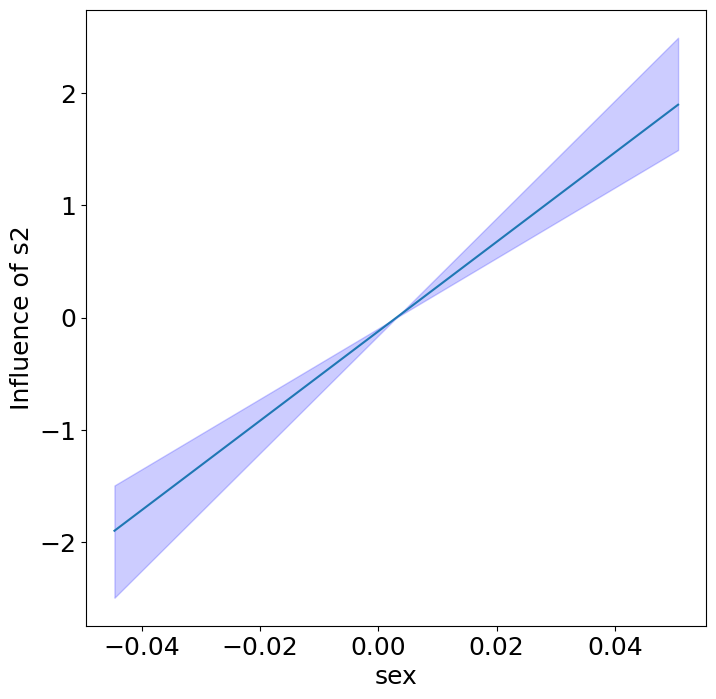

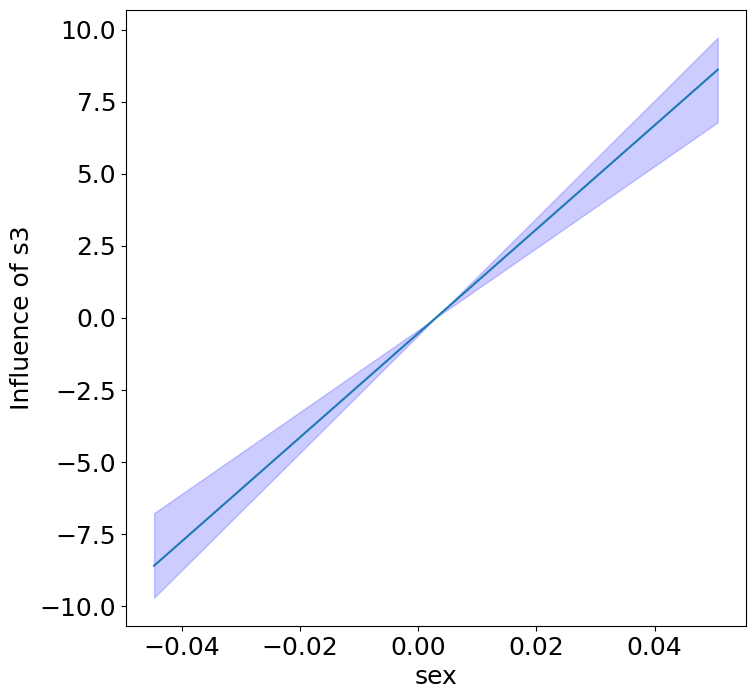

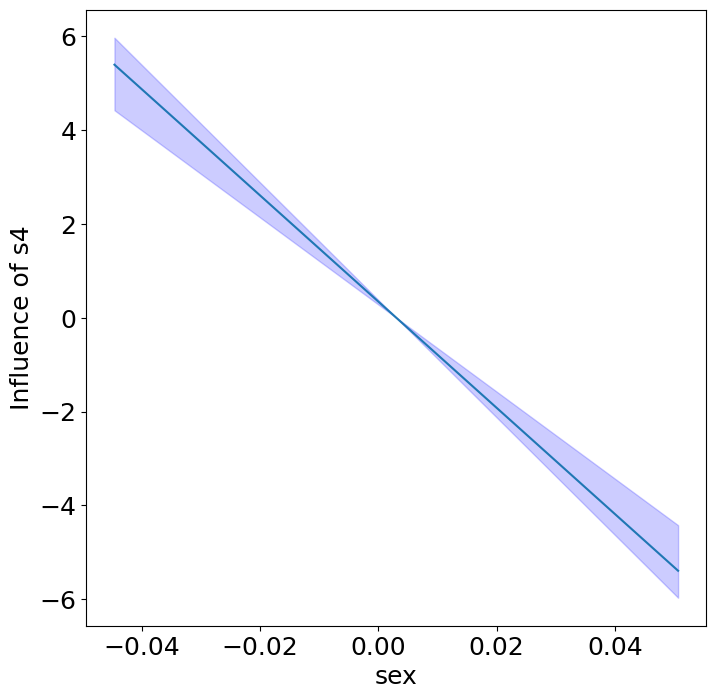

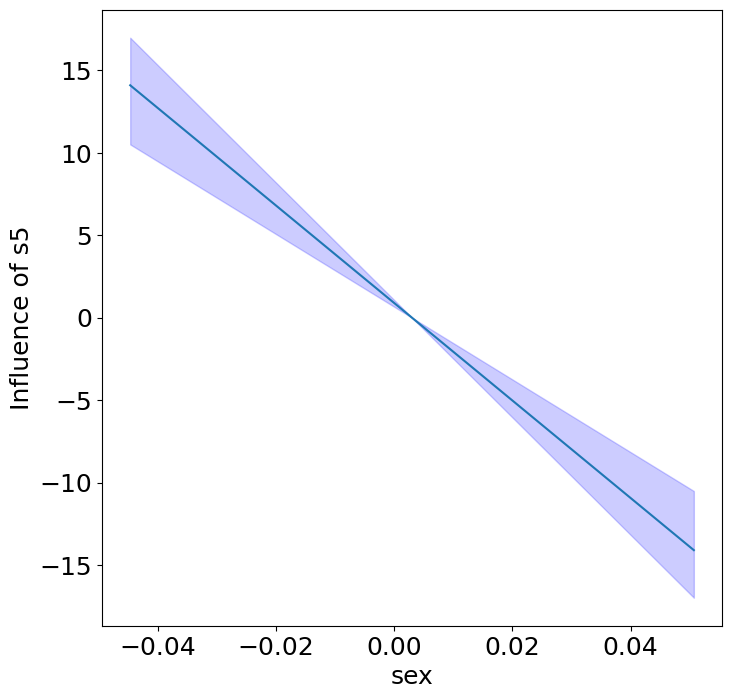

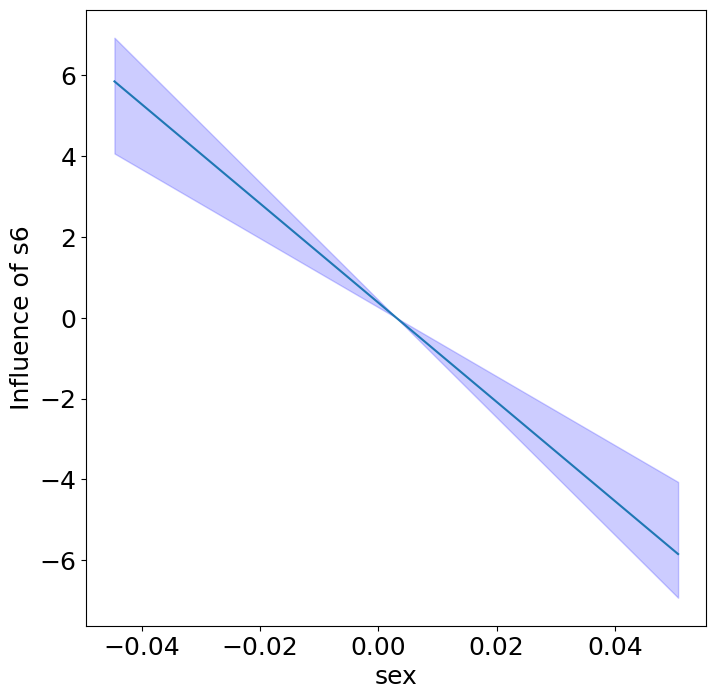

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

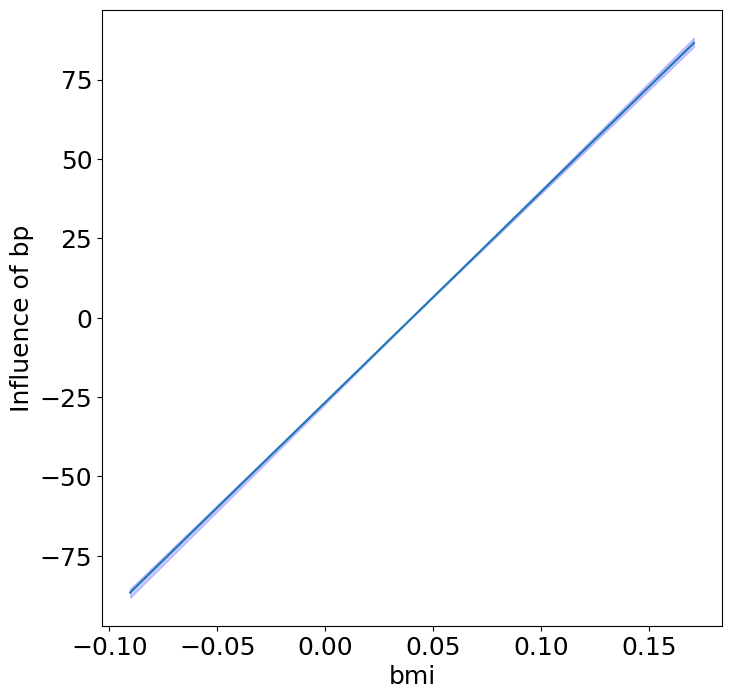

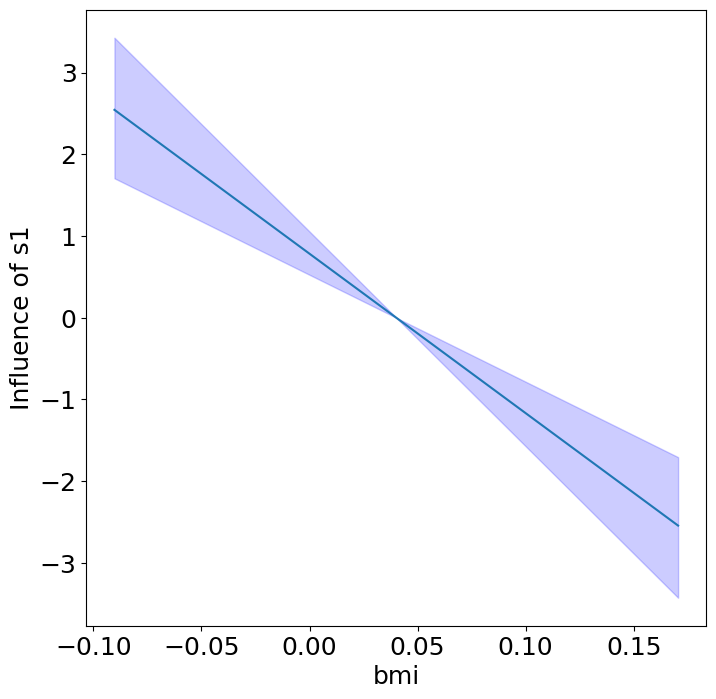

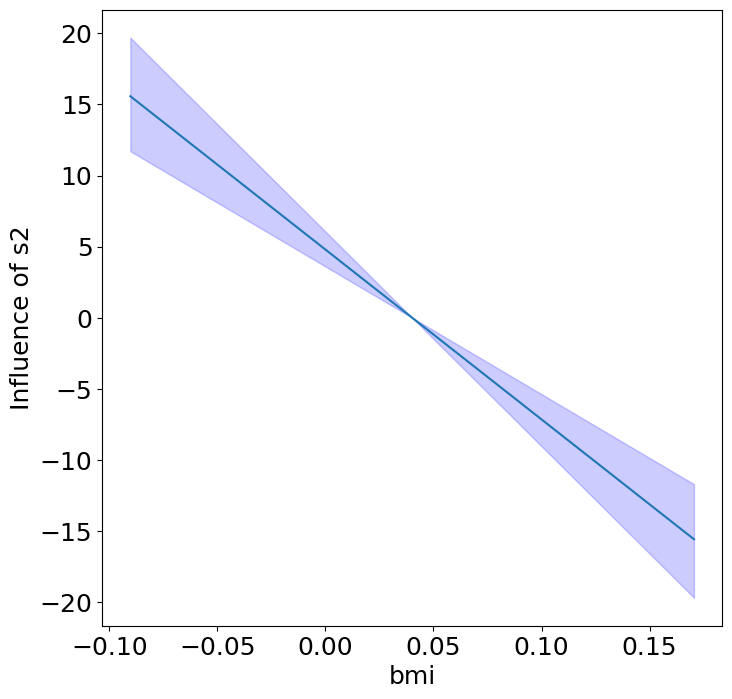

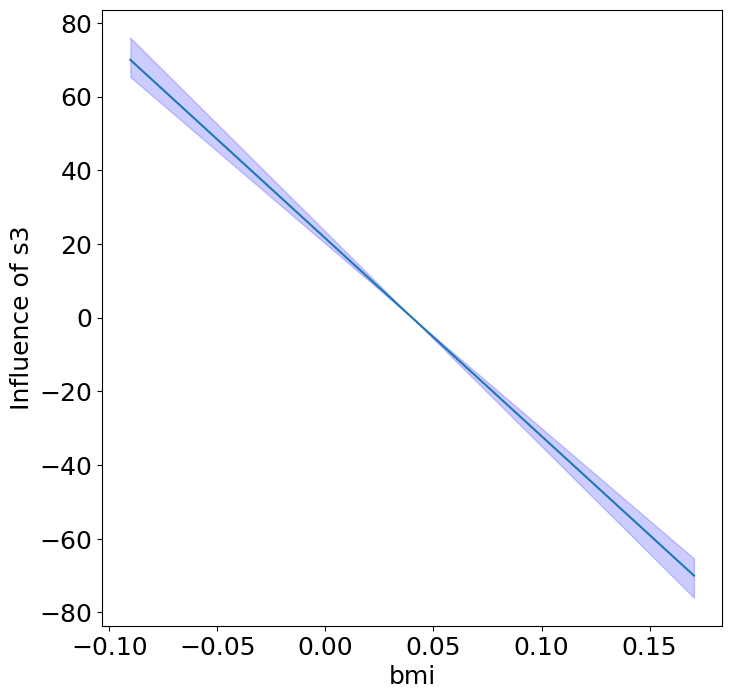

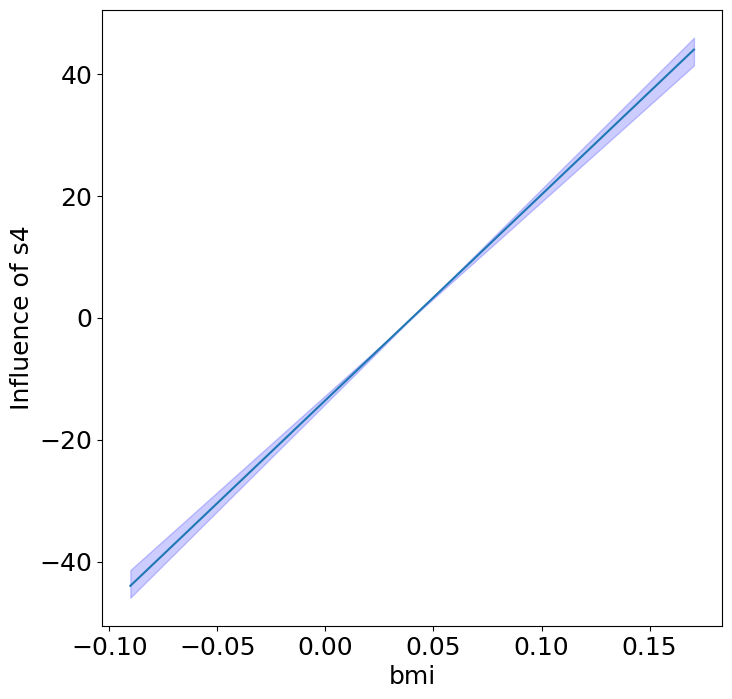

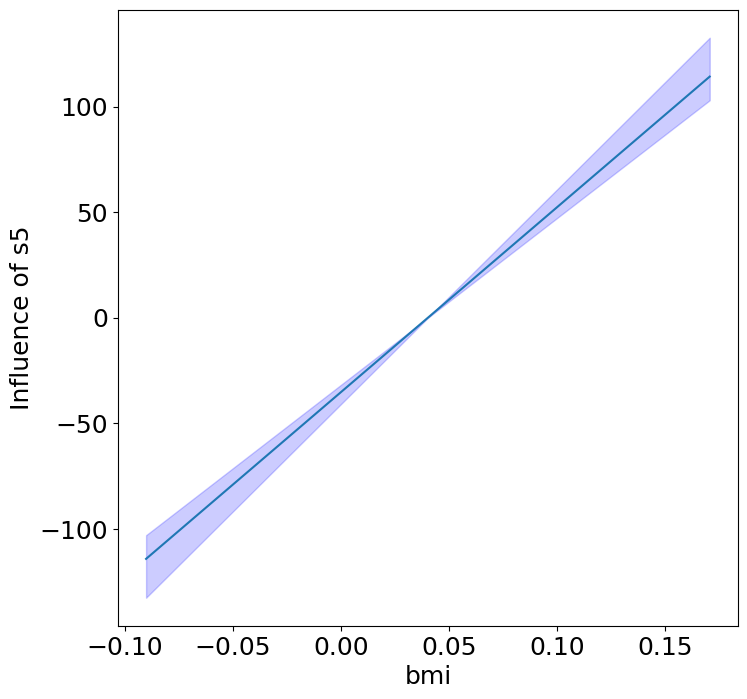

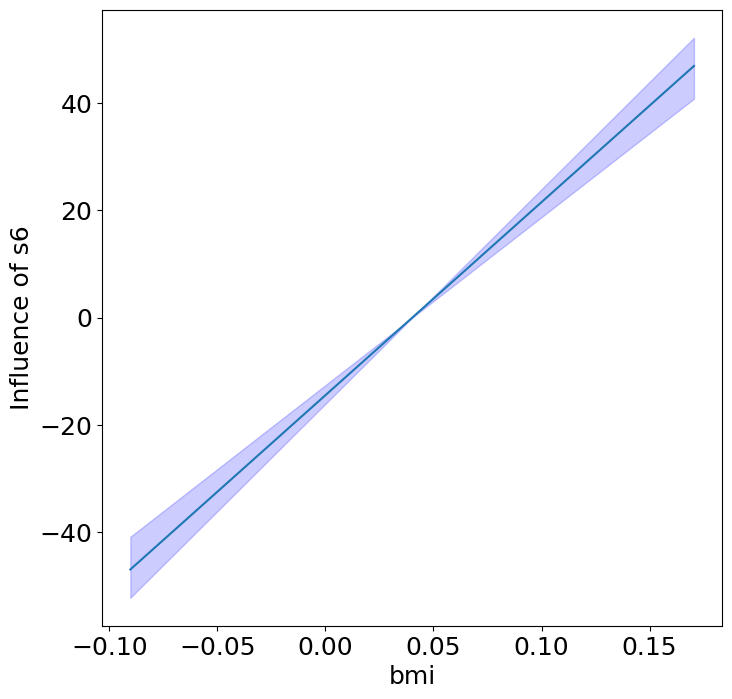

In [8]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=10,
                  ylabel="Influence of")